In [1]:
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
def find_screen(org_image):
    org_image = imutils.resize(org_image, height=500)
    imh = org_image.shape[0]
    imw = org_image.shape[1]
    cropL = 120
    cropR = 254
    
    image = org_image[:, cropL:cropR]
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)
    th2 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY,31, 2)  
    edged = cv2.Canny(th2, 0, 100, 255)
    
    lines = cv2.HoughLines(edged,1,np.pi/180, 1)[0:500]  #assumes descendng order of votes
    lines = np.append(lines, [[[i]] for i in range(len(lines))], axis=2) #mark by order of feature strength
    
    #merge similar lines
    idx = 0 
    while idx < len(lines):
        for jdx in range(idx):
            ri, ti, _ = lines[idx][0]
            rj, tj, _ = lines[jdx][0]
            dt = abs(ti-tj)
            dp = abs(ri-rj)
            if dt < 0.1 and dp < 15:
                lines = np.delete(lines, idx, axis=0)
                idx -= 1
                break
        idx += 1
    
    #find pairs of horizontal parallel lines
    parallel_lines = []
    for i in range(len(lines)):
        for j in range(len(lines)):                           #TODO:remove horizontal restrict
            if j == i: continue
            ri, ti, si = lines[i][0]
            rj, tj, sj = lines[j][0]
            dt = abs(ti-tj)
            dp = abs(ri-rj)
            #parallel, some distance apart, horizontal
            if dt < 0.1 and 75<dp<200 and 1.40<ti<1.70: 
                parallel_lines.append([ri, ti, si, rj, tj, sj])

    parallel_lines.sort(key=lambda p: (p[2]*p[2]+p[5]*p[5]))  #sort by feature strength
    parallel_lines = parallel_lines[:5]
    
    #the screen has bright digits surrounded by a dark background
    #look for this pattern of brightness
    hsvim = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    row_color = np.array([hsvim[i,:,2].max(axis=0) - hsvim[i,:,2].min(axis=0) for i in range(len(hsvim))])
    row_color = np.expand_dims(row_color, axis=1)
    
    best_score = -10**6
    long_edges = None
    for ri, ti, si, rj, tj, sj in parallel_lines:
        hi = int(ri*np.sin(ti))
        hj = int(rj*np.sin(tj))
        region = row_color[min(hi,hj):max(hi,hj), :]
        l = len(region)
        margin = 0.2
        top_value = np.mean(region[:int(margin*l), :])
        btm_value = np.mean(region[-int(margin*l):, :])
        mid_value = np.mean(region[int(margin*l):-int(margin*l), :])
        score = mid_value - 2*(top_value+btm_value)/2   #weighted
        if score > best_score:
            best_score = score
            long_edges = [ri, ti, rj, tj]
    
    if long_edges[0] < long_edges[2]: 
        top_edge = long_edges[:2]
        btm_edge = long_edges[2:]
    else:
        top_edge = long_edges[2:]
        btm_edge = long_edges[:2]
    
    #convert to coordinates in original image
    def endpt_b4_crop(r, t):
        hleft = int((1+cropL*np.cos(t)/r) * r/np.sin(t))
        hright = int((1+(cropL-imw)*np.cos(t)/r) * r/np.sin(t))
        return (0, hleft, imw, hright)
        
    top_endpt = endpt_b4_crop(*top_edge)
    btm_endpt = endpt_b4_crop(*btm_edge)
    
    #might want to crop a rectangle (now a parallelogram)
    screen_row = four_point_transform(org_image, np.array([top_endpt[:2],top_endpt[2:],btm_endpt[2:],btm_endpt[:2]]))
    rgray = cv2.cvtColor(screen_row, cv2.COLOR_BGR2GRAY)
    rblur = cv2.GaussianBlur(rgray,(5,5),0)
    rth2 = cv2.adaptiveThreshold(rblur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                cv2.THRESH_BINARY,101, 2)  #important parameter
    
    kernel = np.ones((5,5),np.uint8)
    closing = cv2.morphologyEx(rth2, cv2.MORPH_CLOSE, kernel)
    col_mean_V = np.mean(closing, axis=0)
    
    #find darkest horizontal region
    expected_width = int(len(screen_row) * 1.8)  #slightly wider
    best_score = -10**6
    best_window = 0
    for window_start in range(len(col_mean_V)-expected_width):
        score = -np.mean(col_mean_V[window_start:window_start+expected_width])  #this can be optimized for speed
        if score > best_score:
            best_score = score
            best_window = window_start
    
    approx_screen = screen_row[:, best_window:best_window+expected_width,:]
    rth2 = rth2[:, best_window:best_window+expected_width]
    
    redged = cv2.Canny(rth2, 0, 100, 255)
    screen_lines = cv2.HoughLines(redged,1,np.pi/180, 1)[0:500]  #assumes descendng order of votes
   
    #merge similar lines
    idx = 0 
    while idx < len(screen_lines):
        for jdx in range(idx):
            ri, ti = screen_lines[idx][0]
            rj, tj = screen_lines[jdx][0]
            dt = abs(ti-tj)
            dp = abs(ri-rj)
            if dt < 0.1 and dp < 15:
                screen_lines = np.delete(screen_lines, idx, axis=0)
                idx -= 1
                break
        idx += 1
    
    #now look the screen's vertical borders
    vertical_lines = []
    for screen_line in screen_lines:
        for r, t in screen_line:
            if -0.1<t<0.1:
                vertical_lines.append([r, t])
    vertical_lines.sort(key=lambda v: v[0])
    
    #don't crop if screen is already bordered by the previous crop
    if vertical_lines[0][0]*np.cos(vertical_lines[0][1]) < expected_width * 1/8:
        left_edge = int(vertical_lines[0][0]*np.cos(vertical_lines[0][1]))
    else:
        left_edge = 0
    
    if vertical_lines[-1][0]*np.cos(vertical_lines[-1][1]) > expected_width * 7/8:
        right_edge = int(vertical_lines[-1][0]*np.cos(vertical_lines[-1][1]))
    else:
        right_edge = expected_width
        
    screen = approx_screen[:,left_edge:right_edge]
    screen = cv2.resize(screen, (350, 200))
    #screen = imutils.rotate(screen, top_edge[1]/np.pi*180-90) #tends to be inaccurate
    
    return screen

In [3]:
def find_digits(screen, segment_area_fraction, width, shear=0.0, has_decimal_pt=False):
    imh, imw, _ = screen.shape 

    #straighten italic digits
    if shear:
        M2 = np.float32([[1, shear, 0], [0, 1, 0]])
        M2[0,2] = -M2[0,1] * imw/2
        M2[1,2] = -M2[1,0] * imh/2
        screen = cv2.warpAffine(screen, M2, (imw, imh))
    
    gray = cv2.cvtColor(screen, cv2.COLOR_BGR2GRAY)
    blurred = cv2.blur(gray,ksize=(15,15))
    dst = cv2.addWeighted(gray, 4, blurred, -4, 128)     #eliminate background illumination
    dst = np.minimum(dst, np.ones(dst.shape) * 255)
    dst = np.maximum(dst, np.zeros(dst.shape)).astype(np.uint8)
    thresh = cv2.threshold(dst,200,255,cv2.THRESH_BINARY)[1]
    
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)[0]

    def bounding_rect(rect1, rect2):
        x1, y1, w1, h1 = rect1
        x2, y2, w2, h2 = rect2
        x = int(min(x1, x2))
        y = int(min(y1, y2))
        w = int(max(x1+w1, x2+w2) - x)
        h = int(max(y1+h1, y2+h2) - y)
        return (x, y, w, h)
    
    #find rectangular bound for digit display
    digit_boundary = (int(imw/2), int(imh/2), 0, 0)
    for cnt in cnts:
        (x, y, w, h) = cv2.boundingRect(cnt) 
        if cv2.contourArea(cnt) >= imh * imw / segment_area_fraction:
            digit_boundary = bounding_rect(digit_boundary, (x, y, w, h))

    x, y, w, h = digit_boundary
    digits = screen[y:y+h, x:x+w]  #add some failproof here
    dgh, dgw, _ = digits.shape
    digits = cv2.resize(digits, (int(60*dgw/dgh), 60))
    dgh, dgw, _ = digits.shape
            
    if not has_decimal_pt:
        digit1 = digits[:,:-width]
        digit2 = digits[:,-width:]
    else:
        digit1 = digits[:,:-(width+13)]
        digit2 = digits[:,-width:]
    
    #resize narrow digits
    def expand_left(digit):
        dgh, dgw, _ = digit.shape
        resized = cv2.resize(digit, (int(60 * dgw/dgh), 60))
        rh, rw, _ = resized.shape
        if rw > 27: return cv2.resize(resized, (27, 60))
        else:
            bg = np.zeros((60, 27, 3)).astype(np.uint8)
            bg[:, 27-rw:] = resized
            return bg     
    
    return expand_left(digit1), expand_left(digit2)

In [4]:
DIGIT_LOOKUP = [
    [1, 1, 1, 0, 1, 1, 1],
    [0, 1, 0, 0, 1, 0, 0],
    [1, 1, 0, 1, 0, 1, 1],
    [1, 1, 0, 1, 1, 0, 1],
    [0, 1, 1, 1, 1, 0, 0],
    [1, 0, 1, 1, 1, 0, 1],
    [1, 0, 1, 1, 1, 1, 1],
    [1, 1, 0, 0, 1, 0, 0],
    [1, 1, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 0, 1]]

def read_digit(digit):
    #read a well-framed, single-digit display
    #60 * 27
    gray = cv2.cvtColor(digit, cv2.COLOR_BGR2GRAY)
    th2 = cv2.threshold(gray, 0, 255,
        cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    total_pixels = np.sum(np.sum(th2))/255
    segment_accumulator = np.zeros(7)    
   
    def region_idx(x, y):
        if 25<=y<=35:
            return 4
        elif y<25:
            if y > 30/27*x:
                if x>=13: return 2
                else: return 3
            else:
                if y > -30/27*x+30: return 2
                else: return 1
        elif y>35:
            if y <= 60 - 30/27*x:
                if x>13: return 5
                else: return 6
            else:
                if y <= 30 + 30/27*x: return 5
                else: return 7
    
    for x in range(27):
        for y in range(60):
            segment_accumulator[region_idx(x, y)-1] += int(th2[y, x]/255)
        
    digit_match = 0
    min_diff = 7
    for digit in range(9, -1, -1):
        expected_segments = DIGIT_LOOKUP[digit]
        #expected fraction of pixels in a segment varies by digit
        num_segments = np.sum(expected_segments)
        segments = [segment_accumulator[i]/total_pixels > 1/(num_segments*2.5) for i in range(7)]
        diff = np.sum([abs(expected_segments[i] - segments[i]) for i in range(7)])
        if diff < min_diff:
            min_diff = diff
            digit_match = digit
    
    return digit_match

(2.5, 99, 83)


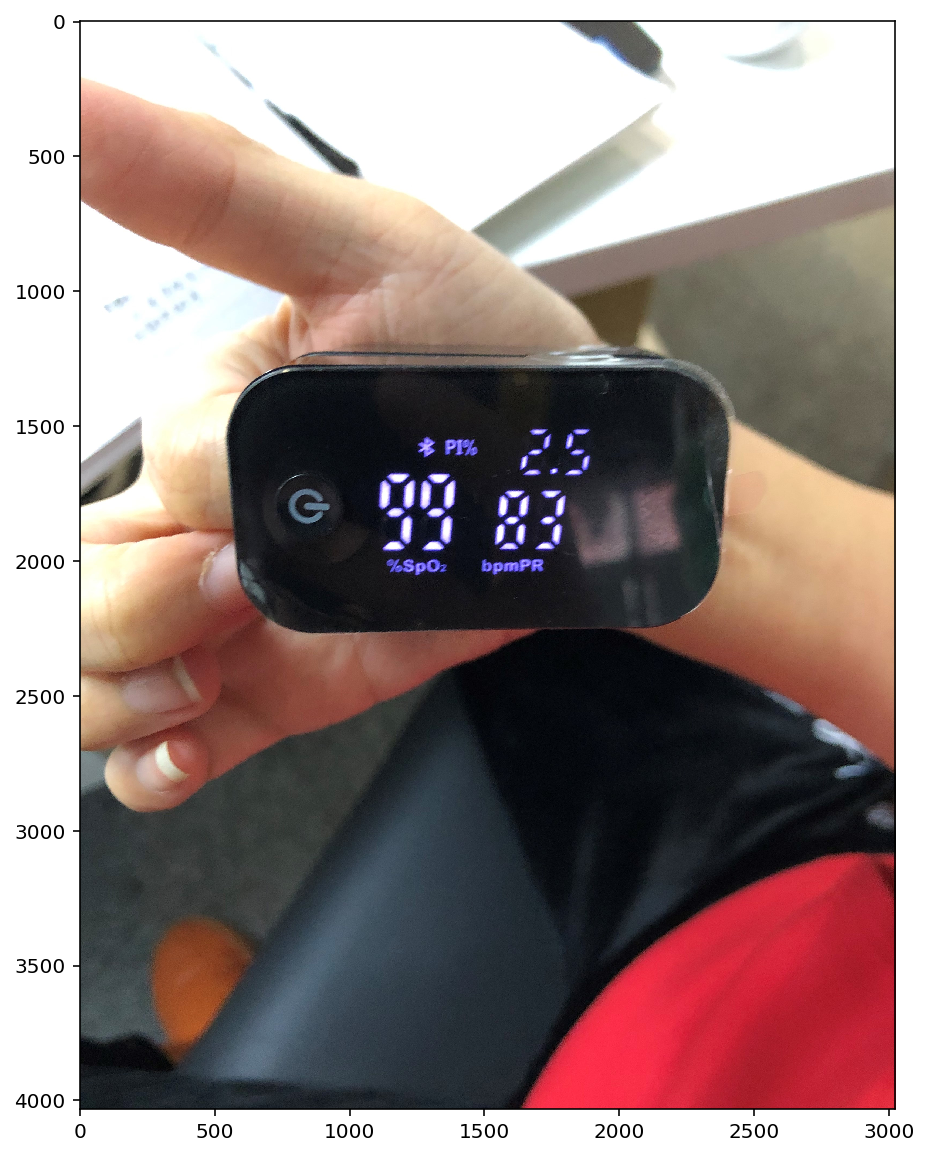

In [5]:
def read_device(image):
    try:
        screen = find_screen(image)
    except Exception as e:
        print("failed to detect device")
    d1, d2 = find_digits(screen[40:90,200:260], 270, 37, 0.1, True)
    d3, d4 = find_digits(screen[70:145,95:170], 150, 28, 0.1, False)
    d5, d6 = find_digits(screen[85:145, 183:243], 150, 32, 0.1, False)
    d1 = read_digit(d1)
    d2 = read_digit(d2)
    d3 = read_digit(d3)
    d4 = read_digit(d4)
    d5 = read_digit(d5)
    d6 = read_digit(d6)
    reading1 = d1 + d2/10
    reading2 = d3*10 + d4
    reading3 = d5*10 + d6
    return reading1, reading2, reading3

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [20, 10]
img = cv2.imread('./images/IMG_2832.JPG')
print(read_device(img))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()